# Set up enviroment

In [1]:
!pip install optuna optuna-integration

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from datetime import datetime
import os
import math
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]
data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "rnn"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 2
# n_split = 0 # 721
n_split = 1 # 622
# n_split = 2 # 811

n_try_opt=100

In [4]:
%cd $data_source

/content/drive/My Drive/Report_DBA/final_report


In [5]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [6]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [7]:
def getSupervisedData(T, TF, train, test, val):

    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Build Model

In [8]:
def RNNModel(trial, T, NFeature):
  drop_out = trial.suggest_float('Dropout_rate', 0.01, 0.1)
  rnn_layers = trial.suggest_int("nLayers", 1, 6)
  hidden_size = trial.suggest_int("Hidden_size", 32, 512, step=16)
  learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)

  model = Sequential()
  model.add(Input(shape=(T, NFeature)))
  for i in range(rnn_layers-1):
        model.add(SimpleRNN(hidden_size,return_sequences=True))
  model.add(SimpleRNN(hidden_size))
  model.add(Dropout(drop_out))
  model.add(Dense(TF))


  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model

## function: objective()

In [9]:
def objective(trial):
    epochs = trial.suggest_int('epoch', 100, 360)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)

    # keras.backend.clear_session()
    # Generate our trial model.
    model = RNNModel(trial,T,NFeature)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        Xtrain,
        Ytrain,
        batch_size=batch_size,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=epochs,
        validation_data=[Xtest, Ytest],
        verbose=0,
    )


    y_pred = model.predict(Xtest)

    # inverse transform
    pred = scaler.inverse_transform(y_pred.reshape(1, -1))
    y_true = scaler.inverse_transform(Ytest.reshape(1, -1))

    # Đánh giá hiệu suất của mô hình
    rmse = np.sqrt(mean_squared_error(y_true, pred))

    return rmse

## Optimize

In [10]:
def optimizedHyperParam():
  start=datetime.now()
  study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())

  study.optimize(objective, n_trials=n_try_opt)

  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

  plot_optimization_history(study)
  return study.best_trial.params

# Start

In [11]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [12]:
Xtrain, Ytrain, Xtest, Ytest, Xval, Yval = getSupervisedData(T, TF, df_train, df_test, df_val)

## TUNING HYPERPARAMS

In [13]:
Xtrain = np.expand_dims(Xtrain, axis=2)

Xtest = np.expand_dims(Xtest, axis=2)

Xval = np.expand_dims(Xval, axis=2)


In [14]:
# best_params = optimizedHyperParam()
# best_params

## TRAINING

In [15]:
def RNNModel_training(rnn_layers, hidden_size, dropout, learning_rate):
  model = Sequential()
  model.add(Input(shape=(T, NFeature)))

  for i in range(rnn_layers-1):
        model.add(SimpleRNN(hidden_size,return_sequences=True))
  model.add(SimpleRNN(hidden_size))
  model.add(Dropout(dropout))
  model.add(Dense(TF))


  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model

In [16]:
# epochs = best_params.get("epoch")
# rnn_layers =  best_params.get("nLayers")
# hidden_size = best_params.get("Hidden_size")
# lr = best_params.get("lr")
# dropout_rate = best_params.get("Dropout_rate")
# batch_size = best_params.get("batch_size")


epochs = 300
rnn_layers =  2
hidden_size = 256
dropout_rate = 0.1
batch_size = 32
learning_rate = 1e-4

model = RNNModel_training(rnn_layers = rnn_layers,
                          hidden_size = hidden_size,
                          dropout = dropout_rate,
                          learning_rate = learning_rate)
history = model.fit(
        Xtrain,
        Ytrain,
        epochs=epochs,
        batch_size=batch_size
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

Epoch 1/300
36/36 [==============================] - 17s 334ms/step - loss: 0.0160
Epoch 2/300
36/36 [==============================] - 14s 389ms/step - loss: 0.0031
Epoch 3/300
36/36 [==============================] - 13s 354ms/step - loss: 0.0028
Epoch 4/300
36/36 [==============================] - 7s 177ms/step - loss: 0.0018
Epoch 5/300
36/36 [==============================] - 7s 183ms/step - loss: 0.0015
Epoch 6/300
36/36 [==============================] - 7s 188ms/step - loss: 0.0012
Epoch 7/300
36/36 [==============================] - 5s 148ms/step - loss: 0.0011
Epoch 8/300
36/36 [==============================] - 8s 222ms/step - loss: 0.0011
Epoch 9/300
36/36 [==============================] - 5s 143ms/step - loss: 0.0012
Epoch 10/300
36/36 [==============================] - 7s 207ms/step - loss: 8.5924e-04
Epoch 11/300
36/36 [==============================] - 6s 159ms/step - loss: 6.4361e-04
Epoch 12/300
36/36 [==============================] - 6s 160ms/step - loss: 6.9368e-0

# Test and Visuliazation

In [17]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [18]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 256)           66048     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 197,633
Trainable params: 197,633
Non-trainable params: 0
_________________________________________________________________


In [19]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict(Xtrain)
y_pred_test = model.predict(Xtest)
y_pred_val = model.predict(Xval)

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

# inverse transform VAL
pred_val = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_true_val = scaler.inverse_transform(Yval.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)
metrics_df = evaluate(metrics_df, "val", y_true_val, pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df


13/13 [==============================] - 1s 42ms/step


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,0.033589,0.019909,0.037781,0.109563,0.083551,0.033605,0.050746,0.037299,0.029524


1/1 [==============================] - 0s 55ms/step


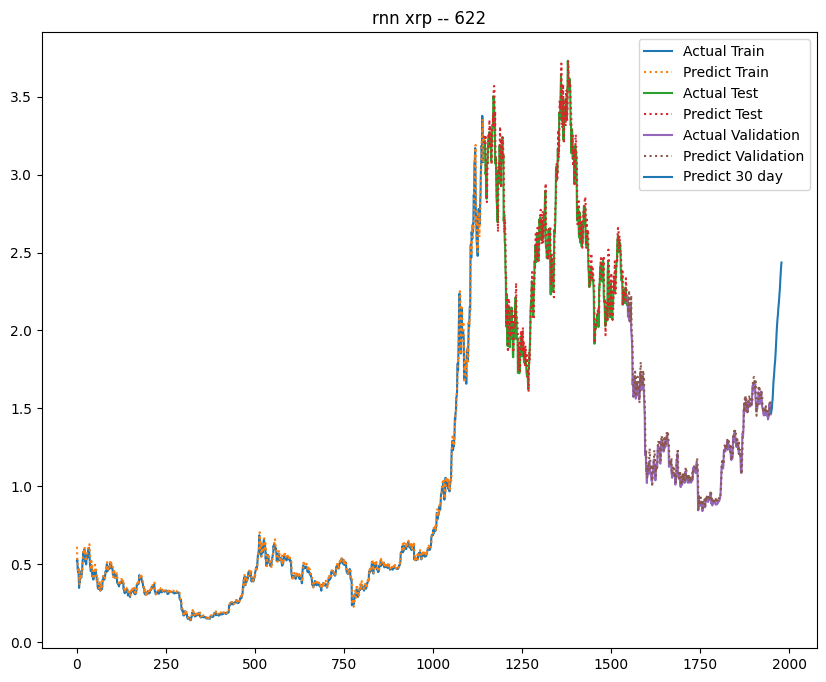

In [20]:
# Predict Next 30 days
npred = 30
i = 0
pred_list = []
input = Yval[-T:]

while i < npred:
  pred = model.predict(input.reshape(1, -1, 1))
  pred_list.append(pred)

  input = np.concatenate([input.squeeze(), pred.reshape(1, )])
  input = input[1:]
  i += 1

pred_list = np.array(pred_list)
pred_list = scaler.inverse_transform(pred_list.reshape(1, -1))

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

# 30 days
pred_range = range(val_range[-1] + 1, val_range[-1] + 1 + 30)
plt.plot([*pred_range], pred_list.squeeze(), label="Predict 30 day")

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()